<a href="https://colab.research.google.com/github/tahaerdem/Things-of-NYC/blob/main/FaultLines%20-%20Safe%20Archive%20-%20APRIL%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install libraries
This usually takes less than 5 minutes on A100. Hit restart session before running the next code, and run it again.

In [ ]:
!pip install torch torchvision
!pip install transformers
!pip install groundingdino
!pip install matplotlib pillow
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
ERROR: Could not 

#2. Import libraries.

In [12]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from lang_sam import LangSAM

#3. Check GPU availability and set the device for CUDA.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#4. Load SAM, GroundingDINO, and checkpoints.

In [13]:
model = LangSAM()

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 15.77 GiB of which 18.38 MiB is free. Process 64540 has 15.75 GiB memory in use. Of the allocated memory 15.26 GiB is allocated by PyTorch, and 120.03 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#5. Defining functions.

In [ ]:
def split_image(image):
    width, height = image.size
    left_half = image.crop((0, 0, width // 2, height))
    right_half = image.crop((width // 2, 0, width, height))
    return left_half, right_half

def find_nearest_row(boxes, image_height):
    nearest_row_boxes = []
    min_distance = float('inf')
    for box in boxes:
        _, y_min, _, y_max = box
        distance = abs((y_min + y_max) / 2 - image_height / 2)
        if distance < min_distance:
            min_distance = distance
            nearest_row_boxes = [box]
        elif distance == min_distance:
            nearest_row_boxes.append(box)
    return nearest_row_boxes

def calculate_centroids(boxes):
    centroids = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        centroids.append((centroid_x, centroid_y))
    return centroids

def calculate_height_distances(centroids):
    distances = []
    for i in range(len(centroids) - 1):
        _, y1 = centroids[i]
        _, y2 = centroids[i + 1]
        distance = abs(y2 - y1)
        distances.append(distance)
    return distances

def calculate_middle_points(centroids):
    middle_points = []
    for i in range(len(centroids) - 1):
        _, y1 = centroids[i]
        _, y2 = centroids[i + 1]
        middle_y = (y1 + y2) / 2
        middle_points.append(middle_y)
    return middle_points

def compare_alignments(left_middle_points, right_middle_points, threshold=10):
    if len(left_middle_points) != len(right_middle_points):
        print("The number of middle points in the two halves is different.")
        return

    for i in range(len(left_middle_points)):
        left_middle = left_middle_points[i]
        right_middle = right_middle_points[i]
        diff = abs(left_middle - right_middle)
        if diff <= threshold:
            print(f"Middle point {i + 1} is aligned. Difference: {diff}")
        else:
            print(f"Middle point {i + 1} is not aligned. Difference: {diff}")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, left_masks, right_masks):
    num_masks = max(len(left_masks), len(right_masks))
    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i in range(num_masks):
        if i < len(left_masks):
            axes[i+1].imshow(left_masks[i], cmap='Blues')
        if i < len(right_masks):
            axes[i+1].imshow(right_masks[i], cmap='Reds', alpha=0.5)
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, left_boxes, right_boxes, left_logits, right_logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(left_boxes, left_logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)
        box_width = x_max - x_min
        box_height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='blue', linewidth=1)
        ax.add_patch(rect)

    left_width = image.size[0] // 2  # Get the width of the left half

    for box, logit in zip(right_boxes, right_logits):
        x_min, y_min, x_max, y_max = box
        x_min += left_width  # Adjust the x-coordinate by adding the width of the left half
        x_max += left_width  # Adjust the x-coordinate by adding the width of the left half
        confidence_score = round(logit.item(), 2)
        box_width = x_max - x_min
        box_height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()

#6. Plot functions.

In [ ]:
image = "/content/drive/MyDrive/FaultLines/original/s-1.png"
text_prompt = "window"

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def process_image(image_path, text_prompt, model):
    try:
        image_pil = Image.open(image_path).convert("RGB")
        left_half, right_half = split_image(image_pil)

        left_masks, left_boxes, left_phrases, left_logits = model.predict(left_half, text_prompt)
        right_masks, right_boxes, right_phrases, right_logits = model.predict(right_half, text_prompt)

        left_nearest_row = find_nearest_row(left_boxes, left_half.size[1])
        right_nearest_row = find_nearest_row(right_boxes, right_half.size[1])

        left_centroids = calculate_centroids(left_nearest_row)
        right_centroids = calculate_centroids(right_nearest_row)

        left_distances = calculate_height_distances(left_centroids)
        right_distances = calculate_height_distances(right_centroids)

        left_middle_points = calculate_middle_points(left_centroids)
        right_middle_points = calculate_middle_points(right_centroids)

        compare_alignments(left_middle_points, right_middle_points)

        if len(left_masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the left half of the image.")
        else:
            left_masks_np = [mask.squeeze().cpu().numpy() for mask in left_masks]
            for i, mask_np in enumerate(left_masks_np):
                mask_path = f"/content/drive/MyDrive/FaultLines/processed/left_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

        if len(right_masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the right half of the image.")
        else:
            right_masks_np = [mask.squeeze().cpu().numpy() for mask in right_masks]
            for i, mask_np in enumerate(right_masks_np):
                mask_path = f"/content/drive/MyDrive/FaultLines/processed/right_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

        display_image_with_masks(image_pil, left_masks_np, right_masks_np)
        display_image_with_boxes(image_pil, left_boxes, right_boxes, left_logits, right_logits)

    except IOError as e:
        print(f"Error processing image {image_path}: {e}")

#7. Image paths

In [ ]:
def main(model):
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    image_paths = [
        "/content/drive/MyDrive/FaultLines/original/s-1.png"
        # Add more image paths as needed
    ]
    text_prompt = "window"

    for image_path in image_paths:
        process_image(image_path, text_prompt, model)

#8. Run the code.

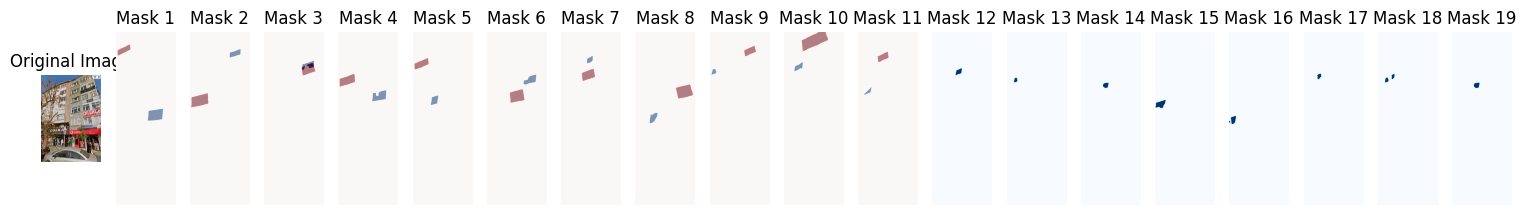

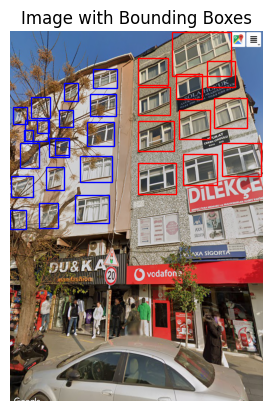

In [ ]:
if __name__ == "__main__":
    main(model)

#5. Define the functions. [DRAFT]

---



In [ ]:
def split_image(image):
    width, height = image.size
    left_half = image.crop((0, 0, width // 2, height))
    right_half = image.crop((width // 2, 0, width, height))
    return left_half, right_half

def find_vertical_rows(boxes, max_horizontal_gap=50):
    # Sort the boxes based on the x-coordinate of their centers
    boxes.sort(key=lambda box: (box[0] + box[2]) / 2)

    vertical_rows = []
    current_row = [boxes[0]]

    for box in boxes[1:]:
        # Check if the box is close enough to the current row (horizontally)
        last_box_in_row = current_row[-1]
        if (box[0] + box[2]) / 2 - (last_box_in_row[0] + last_box_in_row[2]) / 2 < max_horizontal_gap:
            current_row.append(box)
        else:
            # Sort the current row by the y-coordinate before adding to the rows list
            current_row.sort(key=lambda box: box[1])
            vertical_rows.append(current_row)
            current_row = [box]

    # Don't forget to add the last row
    current_row.sort(key=lambda box: box[1])
    vertical_rows.append(current_row)

    return vertical_rows

def calculate_centroids(boxes):
    centroids = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        centroid_x = (x_min + x_max) / 2
        centroid_y = (y_min + y_max) / 2
        centroids.append((centroid_x, centroid_y))
    return centroids

def calculate_height_distances(centroids):
    distances = []
    for i in range(len(centroids) - 1):
        _, y1 = centroids[i]
        _, y2 = centroids[i + 1]
        distance = abs(y2 - y1)
        distances.append(distance)
    return distances

def calculate_middle_points(centroids):
    middle_points = []
    for i in range(len(centroids) - 1):
        _, y1 = centroids[i]
        _, y2 = centroids[i + 1]
        middle_y = (y1 + y2) / 2
        middle_points.append(middle_y)
    return middle_points

def compare_alignments(left_middle_points, right_middle_points, threshold=20):
    if len(left_middle_points) != len(right_middle_points):
        print("The number of middle points in the two halves is different.")
        return

    for i in range(len(left_middle_points)):
        left_middle = left_middle_points[i]
        right_middle = right_middle_points[i]
        diff = abs(left_middle - right_middle)
        if diff <= threshold:
            print(f"Middle point {i + 1} is aligned. Difference: {diff}")
        else:
            print(f"Middle point {i + 1} is not aligned. Difference: {diff}")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, left_masks, right_masks):
    num_masks = max(len(left_masks), len(right_masks))
    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i in range(num_masks):
        if i < len(left_masks):
            axes[i+1].imshow(left_masks[i], cmap='Blues')
        if i < len(right_masks):
            axes[i+1].imshow(right_masks[i], cmap='Reds', alpha=0.5)
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, left_boxes, right_boxes, left_logits, right_logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(left_boxes, left_logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)
        box_width = x_max - x_min
        box_height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='blue', linewidth=1)
        ax.add_patch(rect)

    left_width = image.size[0] // 2  # Get the width of the left half

    for box, logit in zip(right_boxes, right_logits):
        x_min, y_min, x_max, y_max = box
        x_min += left_width  # Adjust the x-coordinate by adding the width of the left half
        x_max += left_width  # Adjust the x-coordinate by adding the width of the left half
        confidence_score = round(logit.item(), 2)
        box_width = x_max - x_min
        box_height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()

def display_image_with_nearest_boxes(image, left_vertical_row, right_vertical_row):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Nearest Bounding Boxes")
    ax.axis('off')

    left_width = image.size[0] // 2  # Get the width of the left half

    # Draw a vertical line at the centerline
    ax.axvline(x=left_width, color='green', linestyle='--', linewidth=1)

    # Find the maximum-x value bounding box on the left side
    if left_vertical_row:
        left_max_x_box = max(left_vertical_row, key=lambda box: box[2])
        x_min, y_min, x_max, y_max = left_max_x_box
        box_width = x_max - x_min
        box_height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='magenta', linewidth=2)
        ax.add_patch(rect)

    # Find the maximum-x value bounding box on the right side
    if right_vertical_row:
        right_max_x_box = max(right_vertical_row, key=lambda box: box[2])
        x_min, y_min, x_max, y_max = right_max_x_box
        x_min += left_width  # Adjust the x-coordinate by adding the width of the left half
        x_max += left_width  # Adjust the x-coordinate by adding the width of the left half
        box_width = x_max - x_min
        box_height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='magenta', linewidth=2)
        ax.add_patch(rect)

    for box in left_vertical_row:
        x_min, y_min, x_max, y_max = box
        box_width = x_max - x_min
        box_height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='blue', linewidth=1)
        ax.add_patch(rect)

    for box in right_vertical_row:
        x_min, y_min, x_max, y_max = box
        x_min += left_width  # Adjust the x-coordinate by adding the width of the left half
        x_max += left_width  # Adjust the x-coordinate by adding the width of the left half
        box_width = x_max - x_min
        box_height = y_max - y_min
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()

In [ ]:
def process_image(image_path, text_prompt, model):
    try:
        image_pil = Image.open(image_path).convert("RGB")
        left_half, right_half = split_image(image_pil)

        left_masks, left_boxes, left_phrases, left_logits = model.predict(left_half, text_prompt)
        right_masks, right_boxes, right_phrases, right_logits = model.predict(right_half, text_prompt)

        left_vertical_rows = find_vertical_rows(left_boxes, left_half.size[0])
        right_vertical_rows = find_vertical_rows(right_boxes, right_half.size[0])

        left_centroids = calculate_centroids(left_vertical_rows)
        right_centroids = calculate_centroids(right_vertical_rows)

        left_distances = calculate_height_distances(left_centroids)
        right_distances = calculate_height_distances(right_centroids)

        left_middle_points = calculate_middle_points(left_centroids)
        right_middle_points = calculate_middle_points(right_centroids)

        compare_alignments(left_middle_points, right_middle_points)

        if len(left_masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the left half of the image.")
        else:
            left_masks_np = [mask.squeeze().cpu().numpy() for mask in left_masks]
            for i, mask_np in enumerate(left_masks_np):
                mask_path = f"/content/drive/MyDrive/FaultLines/original/left_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

        if len(right_masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the right half of the image.")
        else:
            right_masks_np = [mask.squeeze().cpu().numpy() for mask in right_masks]
            for i, mask_np in enumerate(right_masks_np):
                mask_path = f"/content/drive/MyDrive/FaultLines/original/right_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

        display_image_with_masks(image_pil, left_masks_np, right_masks_np)
        display_image_with_boxes(image_pil, left_boxes, right_boxes, left_logits, right_logits)
        display_image_with_nearest_boxes(image_pil, left_vertical_rows, right_vertical_rows)

    except IOError as e:
        print(f"Error processing image {image_path}: {e}")

In [ ]:
if __name__ == "__main__":
    main(model)

TypeError: sort() received an invalid combination of arguments - got (key=function, ), but expected one of:
 * (*, bool stable, int dim, bool descending)
 * (int dim, bool descending)
 * (*, bool stable, name dim, bool descending)
 * (name dim, bool descending)
